<a href="https://colab.research.google.com/github/Akhilez/ml_gallery/blob/master/ml_py/MLGallery/selective_generator/CustomCNNClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

File path: https://github.com/Akhilez/ml_gallery/blob/master/ml_py/MLGallery/selective_generator/CustomCNNClassifier.ipynb

In [0]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from torch.nn.functional import dropout, leaky_relu, binary_cross_entropy, softmax
from torch import sigmoid
from torch.nn import Conv2d, Linear
from random import random

In [3]:
data_path = "./data/mnist/"

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_path, train=True, download=True,
                               transform=torchvision.transforms.ToTensor()), shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_path, train=False, download=True,
                               transform=torchvision.transforms.ToTensor()), shuffle=True)

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw
Processing...
Done!


In [0]:
def to_one_hot(x):
    b = np.zeros((len(x), 10))
    b[np.arange(len(x)), x] = 1
    return b

In [5]:
x_test = []
y_test = []

for data in test_loader:
    x_test.append(data[0].reshape(1, 28, 28).numpy())
    y_test.append(data[1][0])

y_test = torch.Tensor(to_one_hot(y_test))
x_test = torch.Tensor(x_test)

In [0]:
x_train = []
y_train = []

for data in test_loader:
    x_train.append(data[0].reshape(1, 28, 28).numpy())
    y_train.append(data[1][0])

y_train = torch.Tensor(to_one_hot(y_train))
x_train = torch.Tensor(x_train)

In [0]:
x_train = x_train[:5000]
x_test = x_test[:500]
y_train = y_train[:5000]
y_test = y_test[:500]

In [8]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

print(torch.min(x_test))
print(torch.max(x_test))

torch.Size([5000, 1, 28, 28]) torch.Size([500, 1, 28, 28]) torch.Size([5000, 10]) torch.Size([500, 10])
tensor(0.)
tensor(1.)


In [0]:
def plot_image(x):
    plt.imshow(x.reshape((28, 28)), cmap='gray')
    # plt.show()

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])


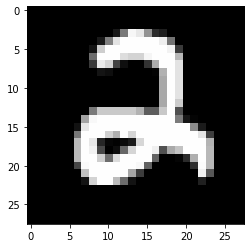

In [10]:
index = 12
plot_image(x_test[index].numpy())
print(y_test[index])
plt.show()

In [0]:
def get_random(shape, min_=-0.5, max_=0.5):
    return torch.FloatTensor(*shape).uniform_(min_, max_).requires_grad_()

Params:

```yaml
input: (b, 1, 28, 28)

conv1:
    input: (b, 1, 28, 28)
    kernel_size: (3, 3)
    weights: (28, 3, 3)
    biases: 28
    stride: 1
    padding: 1
    output: (b, 28, 28, 28)
    activation: relu

fcc1:
    input: (b, 28**3)
    weights: (28**3, 128)
    biases: 1000
    output: (b, 128)
    activation: sigmoid

fcc2:
    input: (b, 128)
    weights: (128, 10)
    biases: 10
    output: (b, 10)
    activation: softmax

```

In [0]:
def pad2D(x):
    padded_x = torch.zeros((x.shape[0], x.shape[1], x.shape[2]+2, x.shape[3]+2))
    padded_x[:, :, 1:x.shape[2]+1, 1:x.shape[3]+1] = x
    return padded_x

In [0]:
class Conv2D(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=False):
        super(Conv2D, self).__init__()
        self.w = get_random((out_channels, in_channels * kernel_size * kernel_size))
        self.b = torch.zeros(out_channels, requires_grad=True)
        self.out_channels = out_channels
        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def forward(self, x, **kwargs):

        # Add padding if asked
        if self.padding:
            x = pad2D(x)

        # Create the output tensor
        output = torch.zeros((
            x.shape[0], 
            self.out_channels, 
            (x.shape[2] - self.kernel_size) // self.stride + 1,  # (w - k +2p)/s + 1
            (x.shape[3] - self.kernel_size) // self.stride + 1
        ))

        # Convolutions loops
        for i in range(0, x.shape[2] - self.kernel_size + 1, self.stride):
            for j in range(0, x.shape[3] - self.kernel_size + 1, self.stride):
                # Input to kernel
                cropped_x = x[:, :, i:i+self.kernel_size, j:j+self.kernel_size]
                
                # Flattening the input into 1D
                input_x = cropped_x.reshape((-1, cropped_x.shape[1] * cropped_x.shape[2] * cropped_x.shape[3]))

                # Computing the matrix multiplication
                h1 = input_x.matmul(self.w.T) + self.b

                # Add the result to the output tensor
                output[:, :, i // self.stride, j // self.stride] = h1

        return output

    def optimize(self, lr):
        self.w = (self.w - lr * self.w.grad).detach().requires_grad_()
        self.b = (self.b - lr * self.b.grad).detach().requires_grad_()

    def parameters(self):
        return {'params': [self.w, self.b]}

In [0]:
class FC(torch.nn.Module):
    def __init__(self, inputs, units):
        super(FC, self).__init__()
        self.w = get_random((inputs, units))
        self.b = torch.zeros(units, requires_grad=True)
        self.units = units
        self.inputs = inputs

    def forward(self, x):
        h1 = x.matmul(self.w) + self.b
        return h1

    def optimize(self, lr):
        self.w = (self.w - lr * self.w.grad).detach().requires_grad_()
        self.b = (self.b - lr * self.b.grad).detach().requires_grad_()

    def parameters(self):
        return {'params': [self.w, self.b]}

In [0]:
class Classifier (torch.nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = Conv2D(1, 28, 3, 1, True)
        self.fc1 = FC(28 * 28 * 28, 128)
        self.fc2 = FC(128, 10)


    def forward(self, x):
        h1 = torch.relu(self.conv1(x))
        h1 = h1.reshape(h1.shape[0], -1)  # flatten
        h2 = torch.sigmoid(self.fc1(h1))
        h3 = torch.nn.functional.softmax(self.fc2(h2))
        return h3

    def optimize(self):
        self.conv1.optimize(0.5)
        self.fc1.optimize(0.5)
        self.fc2.optimize(0.5)

    def parameters(self):
        return [layer.parameters() for layer in (self.conv1, self.fc1, self.fc2)]

In [0]:
model = Classifier()

In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [27]:
batch_size = 200
epochs = 1

for epoch in range(epochs):
    print(f'Epoch: {epoch}')
    losses = 0
    for i in range(0, len(x_train), batch_size):
        start_index = i
        end_index = i+batch_size
        
        x_batch = x_train[start_index:end_index]
        y_batch = y_train[start_index:end_index]

        optimizer.zero_grad()
        y_pred = model(x_batch)
        
        loss = torch.nn.functional.binary_cross_entropy(y_pred, y_batch)
        loss.backward()

        optimizer.step()

        losses += loss

        if i % 300:
            print(f'    Loss: {loss}')        
    print(f'  Loss: {losses}')

Epoch: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


    Loss: 0.48331218957901
    Loss: 0.36139115691185
    Loss: 0.24380314350128174
    Loss: 0.20648902654647827
    Loss: 0.13495022058486938
    Loss: 0.1308947205543518
    Loss: 0.1154150515794754
    Loss: 0.11980539560317993
    Loss: 0.08740951865911484
    Loss: 0.09248927980661392
    Loss: 0.07681242376565933
    Loss: 0.09474394470453262
    Loss: 0.07295730710029602
    Loss: 0.064518503844738
    Loss: 0.06107725948095322
    Loss: 0.06312616914510727
  Loss: 3.893590211868286


In [0]:
batch_size = 200
epochs = 1

for epoch in range(epochs):
    print(f'Epoch: {epoch}')
    losses = 0
    for i in range(0, len(x_train), batch_size):
        start_index = i
        end_index = i+batch_size
        
        x_batch = x_train[start_index:end_index]
        y_batch = y_train[start_index:end_index]

        y_pred = model(x_batch)
        
        loss = torch.nn.functional.binary_cross_entropy(y_pred, y_batch)
        loss.backward()

        model.optimize()

        losses += loss

        if i % 300:
            print(f'    Loss: {loss}')        
    print(f'  Loss: {losses}')

Epoch: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


    Loss: 0.26441535353660583
    Loss: 0.2629656493663788
    Loss: 0.2581695318222046
    Loss: 0.2538660168647766
    Loss: 0.256104439496994
    Loss: 0.2317877858877182
    Loss: 0.23507320880889893
    Loss: 0.23883530497550964
    Loss: 0.2222621738910675
    Loss: 0.24459747970104218
    Loss: 0.2333696484565735
    Loss: 0.21002046763896942
    Loss: 0.21329227089881897
    Loss: 0.2293323427438736
    Loss: 0.2005690038204193
    Loss: 0.20597420632839203
  Loss: 5.937482833862305


343


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


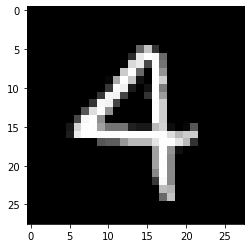

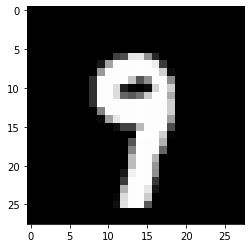

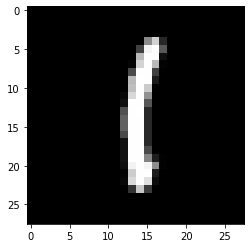

y_pred: tensor([4, 9, 1])
y_real: tensor([4, 9, 1])
tensor(0.0218)


In [30]:
with torch.no_grad():

    index = int(random() * 500)
    print(index)
    batch_size = 3

    x_sample = x_test[index:index+batch_size]
    y_sample = y_test[index:index+batch_size]

    y_pred = model(x_sample)

    for img in range(batch_size):
        plot_image(x_sample[img].numpy())
        plt.show()

    value, y_pred_int = y_pred.max(1)
    value, y_real_int = y_sample.max(1)

    print(f'y_pred: {y_pred_int}\ny_real: {y_real_int}')

    loss = torch.nn.functional.binary_cross_entropy(y_pred, y_sample)

    print(loss)
